In [20]:
%load_ext autoreload
%autoreload 1
%matplotlib widget
import pandas as pd

df = pd.read_hdf('data/binance_BTC_USDT.h5')
df.index = pd.DatetimeIndex(df.index * 10 ** 9)
df = df[~df.index.duplicated()]

sample_df = df.loc[pd.Timestamp('2022-01-01'):pd.Timestamp('2022-08-01')]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


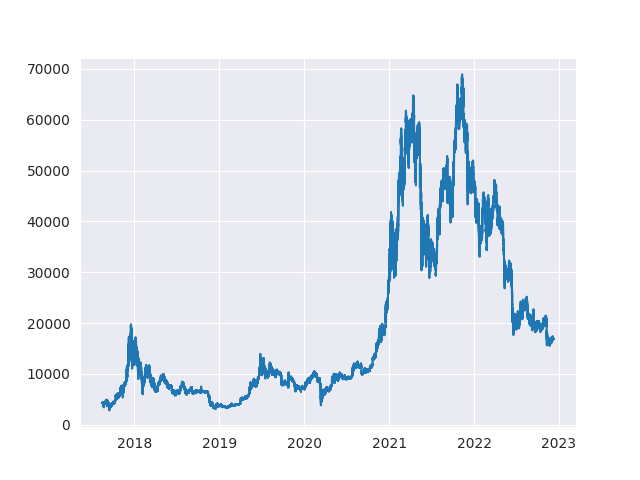

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(df.price)

## Toward a stationary time series

### - Rolling mean and std

Text(0.5, 1.0, 'Series rolling std over 1 month window')

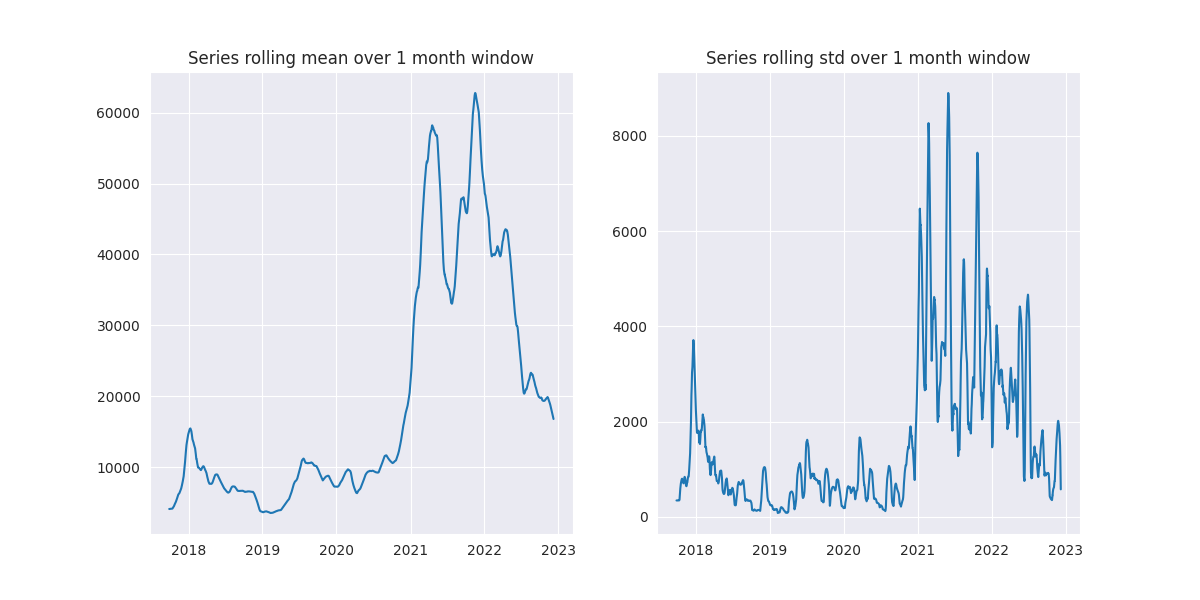

In [22]:
rolling_mean = df['price'].rolling(60 * 24 * 30).mean()
rolling_std = df['price'].rolling(60 * 24 * 30).std()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(rolling_mean)
axes[0].set_title('Series rolling mean over 1 month window')
axes[1].plot(rolling_std)
axes[1].set_title('Series rolling std over 1 month window')

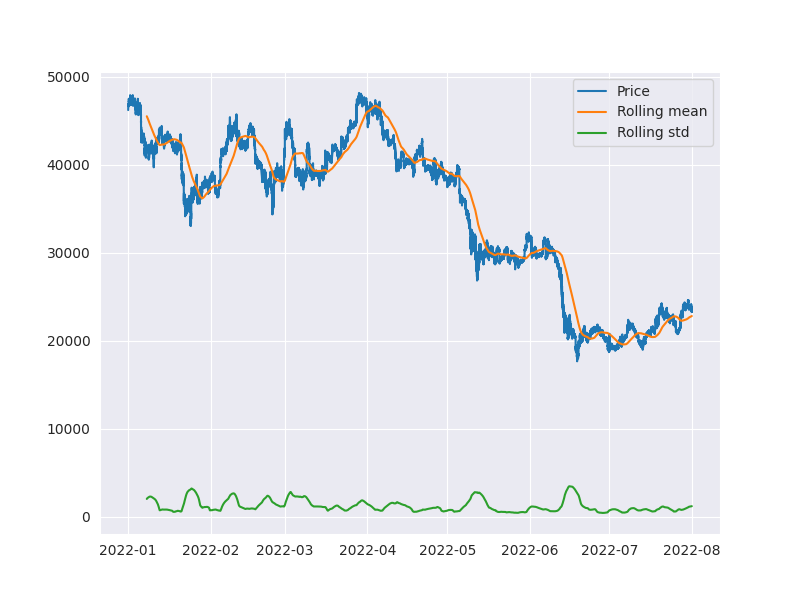

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(sample_df['price'], label='Price')
plt.plot(sample_df['price'].rolling(60 * 24 * 7).mean(), label='Rolling mean')
plt.plot(sample_df['price'].rolling(60 * 24 * 7).std(), label='Rolling std')
plt.legend()
plt.show()

In [2]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(sample_df['price'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.0612695774081564
p-value: 0.7302675437641273
Critical Values:
	1%: -3.4303714256858333
	5%: -2.861549469887628
	10%: -2.5667750404775824


In [14]:
print('Used lag:', result[2])
print('NICE!')

Used lag: 69
NICE!


The raw prices won't cut it, how about taking logarithm?

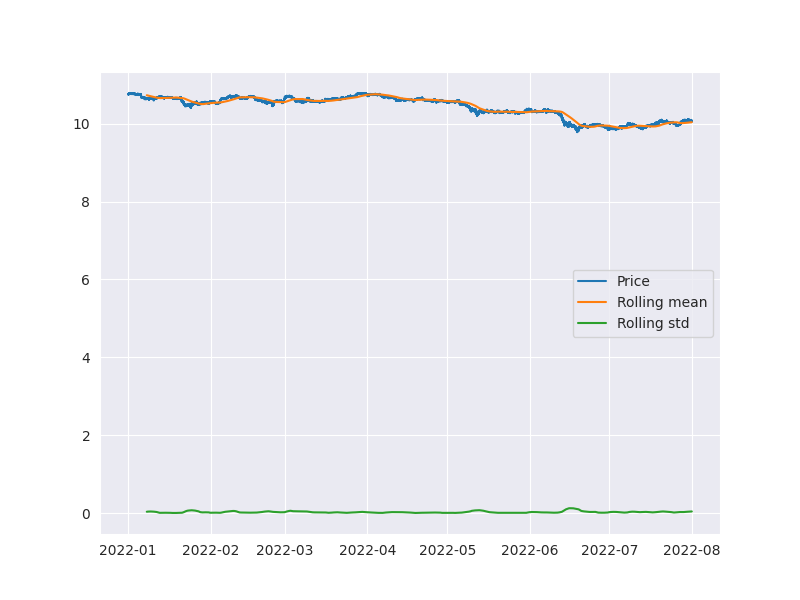

In [3]:
import numpy as np

log_data = np.log(sample_df)

plt.figure(figsize=(8, 6))
plt.plot(log_data['price'], label='Price')
plt.plot(log_data['price'].rolling(60 * 24 * 7).mean(), label='Rolling mean')
plt.plot(log_data['price'].rolling(60 * 24 * 7).std(), label='Rolling std')
plt.legend()
plt.show()

In [20]:
result = adfuller(log_data['price'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -0.9038095906959484
p-value: 0.7867152759967502
Critical Values:
	1%: -3.4303714256858333
	5%: -2.861549469887628
	10%: -2.5667750404775824


Not much better, but we are getting closer, let's try the absolute/relative price change

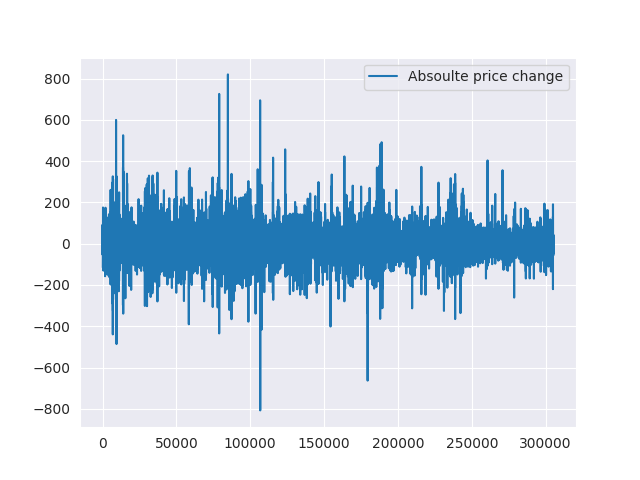

In [23]:
apc = (sample_df['price'][1:].to_numpy() - sample_df['price'][:-1].to_numpy())
rpc = apc / sample_df['price'][:-1].to_numpy()

plt.figure()
plt.plot(apc, label='Absoulte price change')
plt.legend()
plt.show()

In [26]:
result = adfuller(apc)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -57.98759640020007
p-value: 0.0
Critical Values:
	1%: -3.4303714272303485
	5%: -2.8615494705702824
	10%: -2.566775040840935


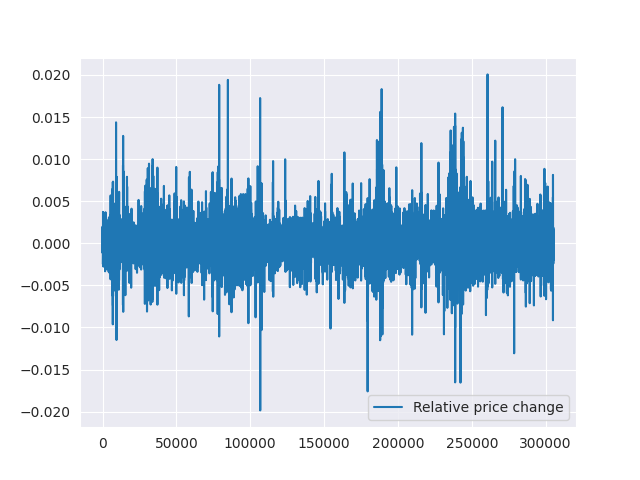

In [25]:
plt.figure()
plt.plot(rpc, label='Relative price change')
plt.legend()
plt.show()

In [27]:
result = adfuller(rpc)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -57.676294557422466
p-value: 0.0
Critical Values:
	1%: -3.4303714272303485
	5%: -2.8615494705702824
	10%: -2.566775040840935


Hmm looks like both the APC and RPC values are stationary time series, who knew.

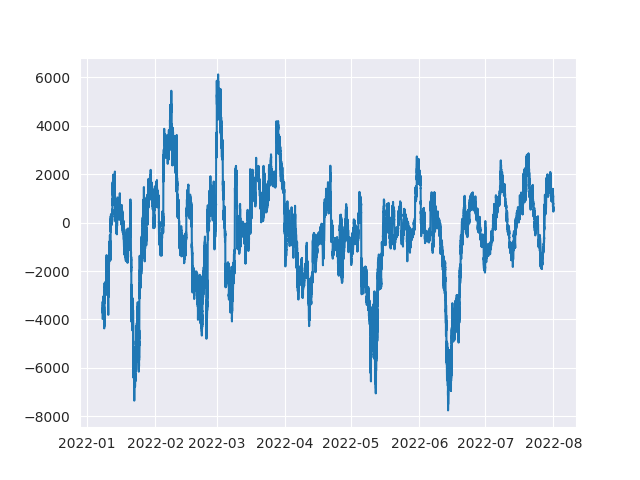

In [30]:
mean_subtracted = (sample_df['price'] - sample_df['price'].rolling(60 * 24 * 7).mean()).dropna()
plt.figure()
plt.plot(mean_subtracted)
plt.show()

In [31]:
result = adfuller(mean_subtracted)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -4.59692409550334
p-value: 0.00013086640162441202
Critical Values:
	1%: -3.4303721573969517
	5%: -2.8615497932936673
	10%: -2.5667752126150933


Using ARIMA with `d=1` seems to be sensible.

In [4]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

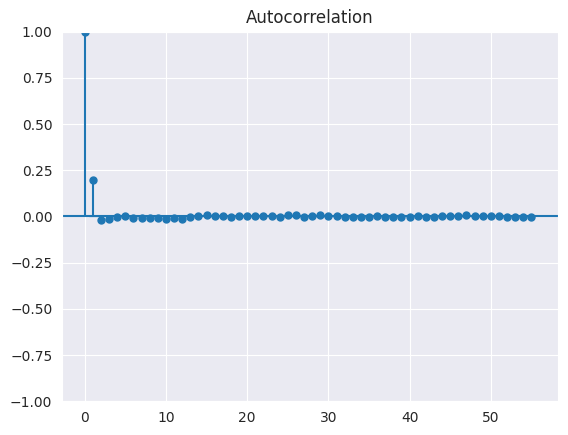

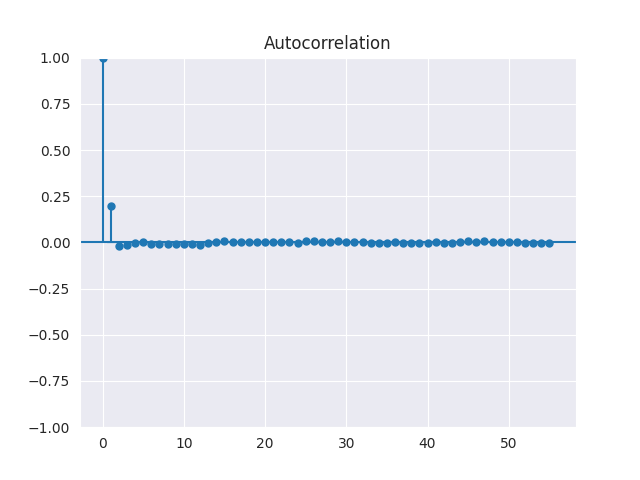

In [5]:
plot_acf(sample_df['price'].diff().dropna())

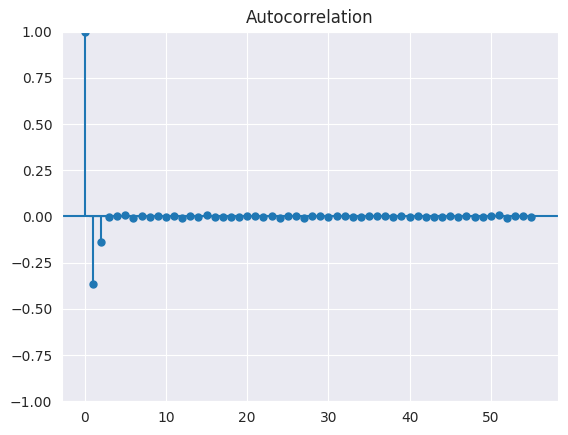

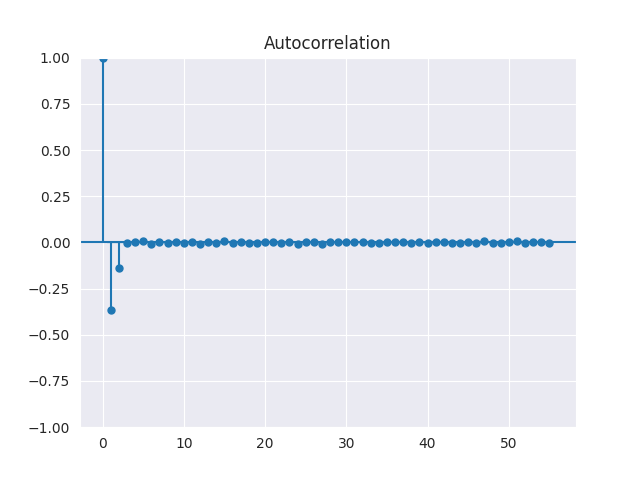

In [6]:
plot_acf(sample_df['price'].diff().diff().dropna())

/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


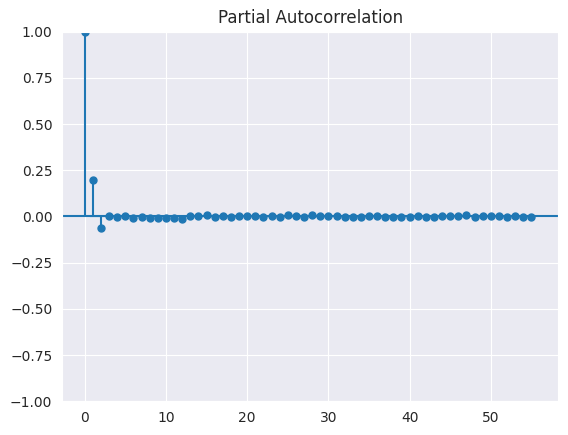

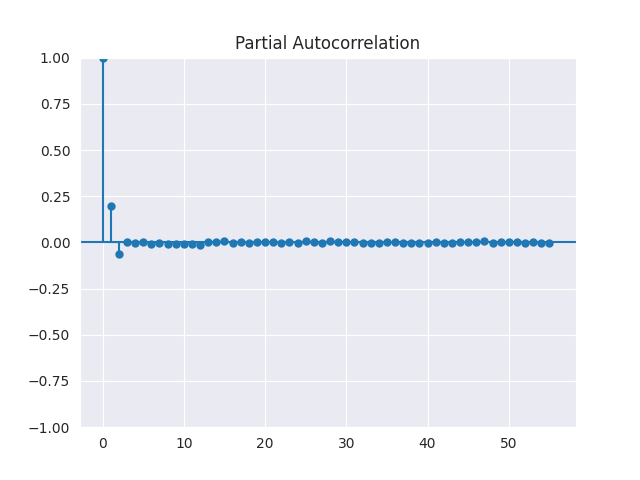

In [7]:
plot_pacf(sample_df['price'].diff().dropna())

In [9]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(sample_df.price, order=(1, 1, 2))
model = arima_model.fit()
print(model.summary())

/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:               305281
Model:                 ARIMA(1, 1, 2)   Log Likelihood            -1455519.754
Date:                Thu, 09 Mar 2023   AIC                        2911047.509
Time:                        21:00:29   BIC                        2911090.025
Sample:                    01-01-2022   HQIC                       2911059.797
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5886      0.029     20.576      0.000       0.533       0.645
ma.L1         -0.3774      0.028    -13.245      0.000      -0.433      -0.322
ma.L2         -0.1417      0.006    -24.622      0.0

In [33]:
arima_model = ARIMA(sample_df.price, enforce_stationarity=True)
model = arima_model.fit()
print(model.summary())

/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:               305281
Model:                          ARIMA   Log Likelihood            -4979128.590
Date:                Thu, 09 Mar 2023   AIC                        9958261.180
Time:                        22:14:27   BIC                        9958282.438
Sample:                    01-01-2022   HQIC                       9958267.324
                         - 08-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.466e+04   4.83e+06      0.007      0.994   -9.44e+06    9.51e+06
sigma2      2.336e+13   8.46e+10    276.260      0.000    2.32e+13    2.35e+13
Ljung-Box (L1) (Q):              305277.19   Jarque-

AttributeError: 'ARIMAResults' object has no attribute 'information'

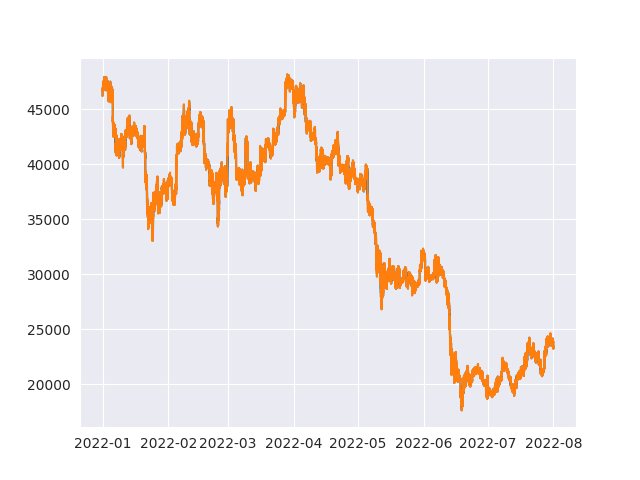

In [29]:
plt.figure()
plt.plot(sample_df.price)
plt.plot(model.fittedvalues[1:])
plt.show()

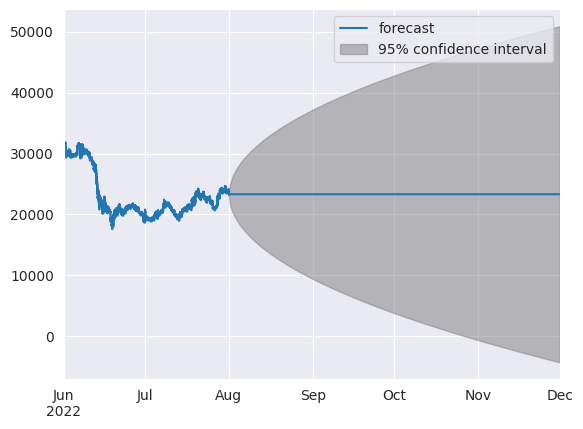

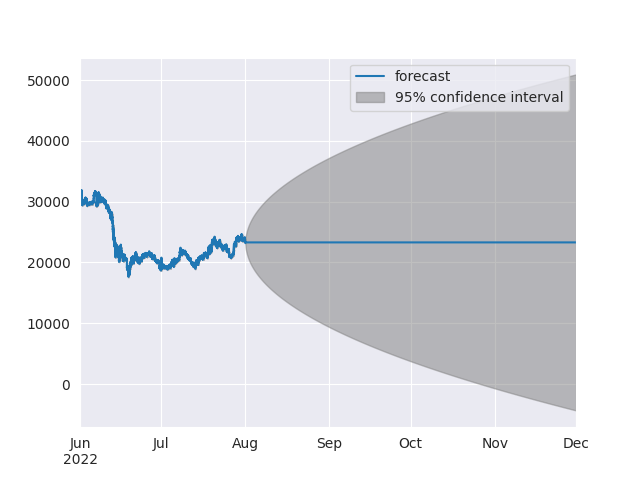

In [30]:
from statsmodels.graphics.tsaplots import plot_predict

plot_predict(model, start='2022-06', end='2022-12')

In [ ]:
from statsmodels.tsa.stattools import arma_order_select_ic

res = arma_order_select_ic(sample_df.price, max_ar=60, max_ma=60, ic='aic', trend='c')

/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/statsmodels/base/model.py:606: